# UniversalityFilter Test Examples

This notebook demonstrates a collection of FSTs designed to exercise the
**UniversalityFilter** optimizations in the decomposition algorithm.

The `UniversalityFilter` is a multi-level short-circuit for determining whether
a DFA powerset state accepts $\Sigma^*$. It has five levels:

1. **all-input-universal fast path**: If the entire FST's input projection accepts $\Sigma^*$, every final state is universal.
2. **ip-universal witness check**: If a powerset state intersects the precomputed witness set (packed `(q, target_len)` for ip-universal states $q$), it's immediately universal.
3. **Superset monotonicity** (element-indexed positive cache): If a known-universal set $S \subseteq$ the current set, the current set is universal too. Uses hit-counting: for each element, increment hit counts of entries containing it; an entry whose count reaches its stored size is a subset.
4. **Subset monotonicity** (element-indexed negative cache): If the current set $\subseteq$ a known non-universal set, it's not universal. Uses set-intersection of entry-ID sets across all elements.
5. **BFS fallback**: Full breadth-first search on the DFA. Results are added to the positive or negative cache for future lookups.

Each test FST below is designed to exercise specific levels of this hierarchy.

**Note:** The epsilon closure in the precover NFA now filters to *productive* states
only (states whose FST state has non-epsilon input arcs, or NFA-final states). This
collapses transit-only epsilon chains, reducing powerset state sizes for BPE-like FSTs.

In [1]:
from transduction import FST, EPSILON, Precover, display_table
from transduction.universality import compute_ip_universal_states, check_all_input_universal
from transduction.rust_bridge import to_rust_fst
import transduction_core

In [2]:
def run_rust(fst, target_syms):
    """Run rust_decompose and return (result, stats)."""
    rust_fst, sym_map, state_map = to_rust_fst(fst)
    target_u32 = [sym_map(y) for y in target_syms]
    result = transduction_core.rust_decompose(rust_fst, target_u32)
    return result, result.stats


def show_stats(stats):
    """Print a summary of universality filter statistics."""
    s = stats
    print(f"  DFA: {s.dfa_states} states, {s.total_arcs} arcs")
    print(f"  q_stops={s.q_stops} (universal), r_stops={s.r_stops} (remainder)")
    print(f"  universal: calls={s.universal_calls}, true={s.universal_true}, false={s.universal_false}")
    print(f"  sub_bfs: states_visited={s.universal_sub_bfs_states}, compute_arcs={s.universal_compute_arcs_calls}")
    print(f"  timing: total={s.total_ms:.3f}ms, universal={s.universal_ms:.3f}ms")
    
    if s.universal_true > 0 and s.universal_sub_bfs_states == 0:
        print(f"  >> ALL {s.universal_true} true results came from witness/cache (zero BFS work!)")
    elif s.universal_calls > 0:
        print(f"  >> BFS explored {s.universal_sub_bfs_states} states for {s.universal_calls} calls")

---
## Test 1: Gated Universal

**What it tests**: ip-universal witness check (level 2)

State 0 is a non-universal "gate" (it only has arcs on `{a, b}`, missing `c`).
State 1 has complete self-loops on `{a, b, c}` &mdash; it is **ip-universal**.
State 2 only has `a` arcs &mdash; it is **not** ip-universal.

The nondeterminism means that after reading one symbol from state 0, the powerset
DFA reaches states containing *both* state 1 and state 2. Since state 1 is
ip-universal, the witness check fires immediately, short-circuiting the full BFS.

In [3]:
def gated_universal(target_len):
    fst = FST()
    fst.add_I(0); fst.add_F(0); fst.add_F(1); fst.add_F(2)
    y = 'y'

    # State 0: gate (has a, b but not c)
    fst.add_arc(0, 'a', y, 1); fst.add_arc(0, 'a', y, 2)
    fst.add_arc(0, 'b', y, 1); fst.add_arc(0, 'b', y, 2)
    fst.add_arc(0, 'a', EPSILON, 0); fst.add_arc(0, 'b', EPSILON, 0)
    fst.add_arc(0, 'c', y, 1)

    # State 1: ip-universal (complete self-loops)
    for x in 'abc':
        fst.add_arc(1, x, y, 1)
        fst.add_arc(1, x, x, 1)

    # State 2: NOT ip-universal (only 'a' arcs)
    fst.add_arc(2, 'a', y, 2)
    fst.add_arc(2, 'a', 'a', 2)

    target = tuple(y for _ in range(target_len))
    return fst, target

all_input_universal: False
ip_universal_states: frozenset({0, 1})
target: ('y', 'y', 'y', 'y', 'y')
functional: ✘ ('a', 'y', '')


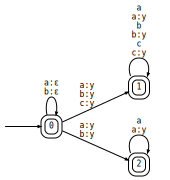

In [7]:
fst, target = gated_universal(5)

ip_univ = compute_ip_universal_states(fst)
aiu = check_all_input_universal(fst)
print(f"all_input_universal: {aiu}")
print(f"ip_universal_states: {ip_univ}")
print(f"target: {target!r}")

is_fun, counterexample = fst.is_functional()
print('functional:', colors.mark(is_fun), repr(counterexample))

display(fst)

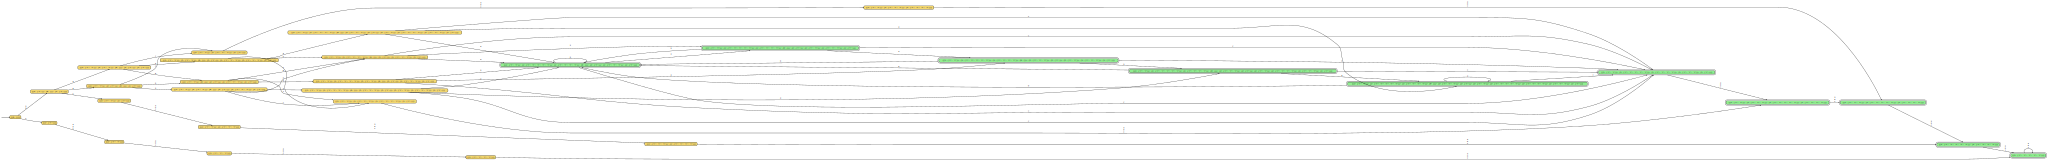

In [8]:
P = Precover(fst, target)
display(P)
P.show_decomposition()

In [9]:
print("Rust profiling stats:")
for tlen in [5, 10, 20]:
    fst, target = gated_universal(tlen)
    _, stats = run_rust(fst, target)
    print(f"\ntarget_len={tlen}:")
    show_stats(stats)

Rust profiling stats:

target_len=5:
  DFA: 31 states, 63 arcs
  q_stops=10 (universal), r_stops=0 (remainder)
  universal: calls=10, true=10, false=0
  sub_bfs: states_visited=0, compute_arcs=0
  timing: total=0.043ms, universal=0.004ms
  >> ALL 10 true results came from witness/cache (zero BFS work!)

target_len=10:
  DFA: 111 states, 273 arcs
  q_stops=20 (universal), r_stops=0 (remainder)
  universal: calls=20, true=20, false=0
  sub_bfs: states_visited=0, compute_arcs=0
  timing: total=0.164ms, universal=0.008ms
  >> ALL 20 true results came from witness/cache (zero BFS work!)

target_len=20:
  DFA: 421 states, 1143 arcs
  q_stops=40 (universal), r_stops=0 (remainder)
  universal: calls=40, true=40, false=0
  sub_bfs: states_visited=0, compute_arcs=0
  timing: total=0.873ms, universal=0.019ms
  >> ALL 40 true results came from witness/cache (zero BFS work!)


Notice that `sub_bfs_states=0` even though `universal_true > 0`. This means **all**
universality conclusions came from the witness check &mdash; zero BFS exploration was needed.
The ip-universal state 1 acts as a "witness" that short-circuits the expensive sub-BFS.

---
## Test 2: Complementary Halves

**What it tests**: BFS fallback and positive cache (levels 5 and 3)

Alphabet `{a, b, c, d}` with 4 states, each covering only half the alphabet:
- State 1: `{a, b}` only
- State 2: `{c, d}` only  
- State 3: `{a, c}` only
- State 4: `{b, d}` only

**No** state is ip-universal (each misses 2 symbols), so the witness check cannot fire.
However, the *union* `{1, 2}` covers all symbols, as does `{3, 4}`. Transitions are
designed to keep complementary pairs together, so universality must be discovered via
the BFS fallback. Once found, the result is stored in the element-indexed positive
cache for future superset-monotonicity lookups.

In [10]:
def complementary_halves(target_len):
    fst = FST()
    fst.add_I(0)
    for s in [1, 2, 3, 4]:
        fst.add_F(s)
    y = 'y'
    symbols = ['a', 'b', 'c', 'd']

    # State 0: dispatcher
    for x in symbols:
        for dest in [1, 2, 3, 4]:
            fst.add_arc(0, x, y, dest)

    # State 1 ({a,b}) -> {1,2}
    for x in ['a', 'b']:
        fst.add_arc(1, x, y, 1); fst.add_arc(1, x, y, 2)
        fst.add_arc(1, x, x, 1); fst.add_arc(1, x, x, 2)

    # State 2 ({c,d}) -> {1,2}
    for x in ['c', 'd']:
        fst.add_arc(2, x, y, 1); fst.add_arc(2, x, y, 2)
        fst.add_arc(2, x, x, 1); fst.add_arc(2, x, x, 2)

    # State 3 ({a,c}) -> {3,4}
    for x in ['a', 'c']:
        fst.add_arc(3, x, y, 3); fst.add_arc(3, x, y, 4)
        fst.add_arc(3, x, x, 3); fst.add_arc(3, x, x, 4)

    # State 4 ({b,d}) -> {3,4}
    for x in ['b', 'd']:
        fst.add_arc(4, x, y, 3); fst.add_arc(4, x, y, 4)
        fst.add_arc(4, x, x, 3); fst.add_arc(4, x, x, 4)

    target = tuple(y for _ in range(target_len))
    return fst, target

all_input_universal: False
ip_universal_states: frozenset()  (empty = no witnesses available)
target: ('y', 'y', 'y', 'y', 'y')
functional: ✘ ('aa', 'yy', 'ya')


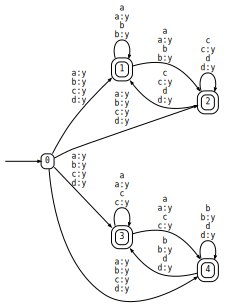

In [11]:
fst, target = complementary_halves(5)

ip_univ = compute_ip_universal_states(fst)
aiu = check_all_input_universal(fst)
print(f"all_input_universal: {aiu}")
print(f"ip_universal_states: {ip_univ}  (empty = no witnesses available)")
print(f"target: {target!r}")

is_fun, counterexample = fst.is_functional()
print('functional:', colors.mark(is_fun), repr(counterexample))

display(fst)

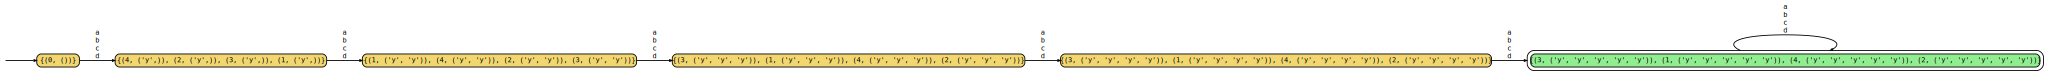

In [12]:
P = Precover(fst, target)
display(P)
P.show_decomposition()

In [13]:
print("Rust profiling stats:")
for tlen in [5, 10, 20]:
    fst, target = complementary_halves(tlen)
    _, stats = run_rust(fst, target)
    print(f"\ntarget_len={tlen}:")
    show_stats(stats)

Rust profiling stats:

target_len=5:
  DFA: 6 states, 20 arcs
  q_stops=1 (universal), r_stops=0 (remainder)
  universal: calls=1, true=1, false=0
  sub_bfs: states_visited=1, compute_arcs=1
  timing: total=0.024ms, universal=0.004ms
  >> BFS explored 1 states for 1 calls

target_len=10:
  DFA: 11 states, 40 arcs
  q_stops=1 (universal), r_stops=0 (remainder)
  universal: calls=1, true=1, false=0
  sub_bfs: states_visited=1, compute_arcs=1
  timing: total=0.029ms, universal=0.003ms
  >> BFS explored 1 states for 1 calls

target_len=20:
  DFA: 21 states, 80 arcs
  q_stops=1 (universal), r_stops=0 (remainder)
  universal: calls=1, true=1, false=0
  sub_bfs: states_visited=1, compute_arcs=1
  timing: total=0.050ms, universal=0.003ms
  >> BFS explored 1 states for 1 calls


Since no state is ip-universal, the witness check doesn't fire. The BFS fallback
must discover that certain powerset states (containing complementary pairs) accept $\Sigma^*$.
The transitions keep `{1,2}` and `{3,4}` as self-contained components, so the powerset
DFA collapses quickly.

---
## Test 3: Shrinking Non-Universal

**What it tests**: Negative cache / subset monotonicity (level 4)

Alphabet `{a, b, c}`. Three states, none covering all symbols:
- State 1: only `a`
- State 2: only `b`  
- State 3: `{a, b}` (still missing `c`)

The set `{1, 2, 3}` is NOT universal (missing `c`). Once discovered,
subsets like `{1, 3}` and `{2, 3}` should be recognized as non-universal
via the negative cache (subset monotonicity), without running BFS again.

In [14]:
def shrinking_nonuniversal(target_len):
    fst = FST()
    fst.add_I(0)
    for s in [1, 2, 3]:
        fst.add_F(s)
    y = 'y'

    # State 0: dispatcher
    for x in 'abc':
        for dest in [1, 2, 3]:
            fst.add_arc(0, x, y, dest)
        fst.add_arc(0, x, EPSILON, 0)  # keep state 0 alive

    # State 1: only 'a'
    fst.add_arc(1, 'a', y, 1)
    fst.add_arc(1, 'a', 'a', 1)

    # State 2: only 'b'
    fst.add_arc(2, 'b', y, 2)
    fst.add_arc(2, 'b', 'b', 2)

    # State 3: {a, b} -> splits on transitions
    fst.add_arc(3, 'a', y, 1); fst.add_arc(3, 'a', 'a', 1)
    fst.add_arc(3, 'b', y, 2); fst.add_arc(3, 'b', 'b', 2)

    target = tuple(y for _ in range(target_len))
    return fst, target

all_input_universal: False
ip_universal_states: frozenset()
target: ('y', 'y', 'y', 'y', 'y')
functional: ✘ ('aa', 'yy', 'ya')


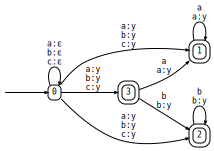

In [16]:
fst, target = shrinking_nonuniversal(5)

ip_univ = compute_ip_universal_states(fst)
aiu = check_all_input_universal(fst)
print(f"all_input_universal: {aiu}")
print(f"ip_universal_states: {ip_univ}")
print(f"target: {target!r}")

is_fun, counterexample = fst.is_functional()
print('functional:', colors.mark(is_fun), repr(counterexample))


display(fst)

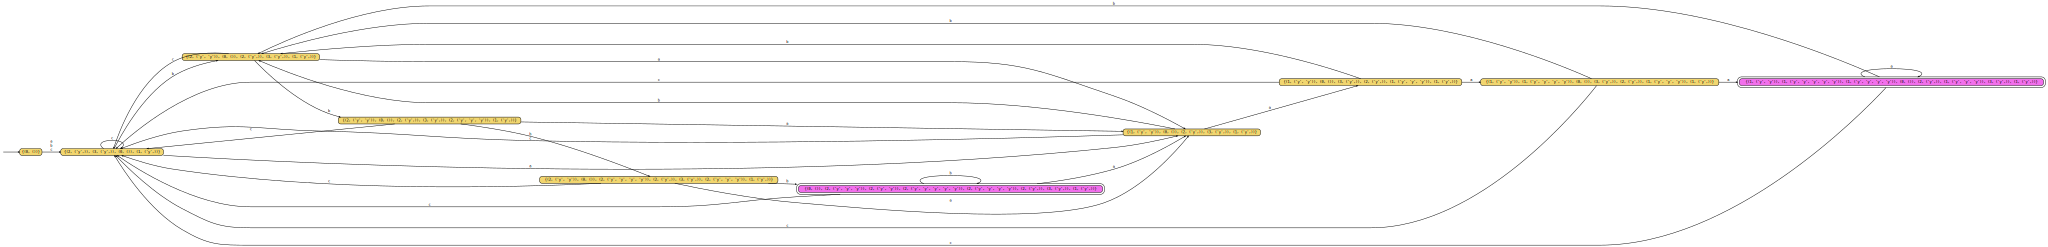

In [17]:
P = Precover(fst, target)
display(P)
P.show_decomposition()

In [18]:
print("Rust profiling stats:")
for tlen in [5, 10, 20]:
    fst, target = shrinking_nonuniversal(tlen)
    _, stats = run_rust(fst, target)
    print(f"\ntarget_len={tlen}:")
    show_stats(stats)

Rust profiling stats:

target_len=5:
  DFA: 10 states, 30 arcs
  q_stops=0 (universal), r_stops=2 (remainder)
  universal: calls=2, true=0, false=2
  sub_bfs: states_visited=2, compute_arcs=2
  timing: total=0.040ms, universal=0.008ms
  >> BFS explored 2 states for 2 calls

target_len=10:
  DFA: 20 states, 60 arcs
  q_stops=0 (universal), r_stops=2 (remainder)
  universal: calls=2, true=0, false=2
  sub_bfs: states_visited=2, compute_arcs=2
  timing: total=0.066ms, universal=0.008ms
  >> BFS explored 2 states for 2 calls

target_len=20:
  DFA: 40 states, 120 arcs
  q_stops=0 (universal), r_stops=2 (remainder)
  universal: calls=2, true=0, false=2
  sub_bfs: states_visited=2, compute_arcs=2
  timing: total=0.112ms, universal=0.010ms
  >> BFS explored 2 states for 2 calls


This FST has **no universal states at all** &mdash; every final DFA state is a remainder state.
The negative cache helps avoid redundant BFS on subsets of previously-seen non-universal sets.
State 3's transitions split into `{1}` or `{2}`, causing the powerset states to shrink
over time.

---
## Test 4: Scaled Newspeak

**What it tests**: Realistic multi-pattern replacement FST

This constructs an FST with `n_patterns` find-and-replace rules over a large alphabet.
State 0 is a passthrough that loops with identity output on all symbols. Each pattern
creates a "mid-state" that captures a triggered replacement.

Because state 0 has identity arcs for every symbol, the FST tends to be
`all_input_universal=True`, which triggers the fast path (level 1) and the
generic decomposition isn't even used. This is a realistic example of how
many practical FSTs end up on the fast path.

In [19]:
def scaled_newspeak(n_patterns, alpha_size, target_len):
    fst = FST()
    fst.add_I(0); fst.add_F(0)
    symbols = [str(i) for i in range(alpha_size)]
    out_symbols = [str(i + alpha_size) for i in range(n_patterns)]

    # State 0: passthrough
    for x in symbols:
        fst.add_arc(0, x, x, 0)

    # Patterns
    for i in range(n_patterns):
        trigger = symbols[i % alpha_size]
        mid_state = i + 1
        fst.add_F(mid_state)
        fst.add_arc(0, trigger, EPSILON, mid_state)
        fst.add_arc(mid_state, symbols[(i+1) % alpha_size], out_symbols[i], 0)
        for x in symbols:
            if x != symbols[(i+1) % alpha_size]:
                fst.add_arc(mid_state, x, x, mid_state)

    target = tuple(out_symbols[i % n_patterns] for i in range(target_len))
    return fst, target

FST: 6 states
all_input_universal: True
ip_universal_states: 6/6
target: ('10', '11', '12', '13', '14', '10', '11', '12', '13', '14')
functional: ✘ ('0', '0', '')


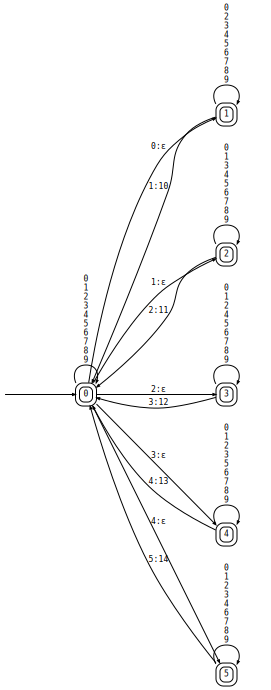

In [21]:
fst, target = scaled_newspeak(5, 10, 10)

ip_univ = compute_ip_universal_states(fst)
aiu = check_all_input_universal(fst)
n_states = len(list(fst.states))
print(f"FST: {n_states} states")
print(f"all_input_universal: {aiu}")
print(f"ip_universal_states: {len(ip_univ)}/{n_states}")
print(f"target: {target!r}")

is_fun, counterexample = fst.is_functional()
print('functional:', colors.mark(is_fun), repr(counterexample))

# Don't display large FSTs graphically
if n_states <= 10:
    display(fst)

In [22]:
print("Rust profiling stats:")
for n_pat, alpha, tlen in [(5, 10, 10), (10, 20, 15)]:
    fst, target = scaled_newspeak(n_pat, alpha, tlen)
    _, stats = run_rust(fst, target)
    aiu = check_all_input_universal(fst)
    print(f"\npatterns={n_pat}, alpha={alpha}, tlen={tlen} (all_input_universal={aiu}):")
    show_stats(stats)

Rust profiling stats:

patterns=5, alpha=10, tlen=10 (all_input_universal=True):
  DFA: 61 states, 60 arcs
  q_stops=1 (universal), r_stops=0 (remainder)
  universal: calls=1, true=1, false=0
  sub_bfs: states_visited=0, compute_arcs=0
  timing: total=0.045ms, universal=0.001ms
  >> ALL 1 true results came from witness/cache (zero BFS work!)

patterns=10, alpha=20, tlen=15 (all_input_universal=True):
  DFA: 166 states, 165 arcs
  q_stops=1 (universal), r_stops=0 (remainder)
  universal: calls=1, true=1, false=0
  sub_bfs: states_visited=0, compute_arcs=0
  timing: total=0.091ms, universal=0.001ms
  >> ALL 1 true results came from witness/cache (zero BFS work!)


Because `all_input_universal=True`, the Rust code dispatches to the `token_decompose`
fast path rather than the generic `decompose` path. The universality filter isn't even
needed &mdash; every final state is trivially universal.

---
## Test 5: Layered Witnesses

**What it tests**: Witness check at scale (level 2)

A chain of $n$ layers, each with 3 states:
- `gate_i`: non-final dispatcher, fans out to the next layer
- `univ_i`: **ip-universal** (complete self-loops on `{a, b}`)
- `partial_i`: NOT ip-universal (only `a` arcs)

With multiple layers, the powerset DFA produces many distinct final states,
each containing at least one ip-universal element. The witness check should
fire for all of them, resulting in zero BFS work.

In [23]:
def layered_witnesses(n_layers, target_len):
    fst = FST()
    y = 'y'
    gate_states, univ_states, partial_states = [], [], []

    for i in range(n_layers):
        g = 3 * i       # gate
        u = 3 * i + 1   # universal
        p = 3 * i + 2   # partial
        gate_states.append(g)
        univ_states.append(u)
        partial_states.append(p)

        fst.add_F(u); fst.add_F(p)

        # Universal state: complete self-loops
        for x in 'ab':
            fst.add_arc(u, x, y, u)
            fst.add_arc(u, x, x, u)

        # Partial state: only 'a'
        fst.add_arc(p, 'a', y, p)
        fst.add_arc(p, 'a', 'a', p)

        # Gate: fans out
        for x in 'ab':
            fst.add_arc(g, x, y, u)
            fst.add_arc(g, x, y, p)
            if i + 1 < n_layers:
                fst.add_arc(g, x, y, 3 * (i + 1))  # next gate
            fst.add_arc(g, x, EPSILON, g)  # stay alive

    fst.add_I(gate_states[0])
    target = tuple(y for _ in range(target_len))
    return fst, target

FST: 9 states
all_input_universal: False
ip_universal_states: frozenset({1, 4, 7})
target: ('y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y')
functional: ✘ ('aa', 'yy', 'ya')


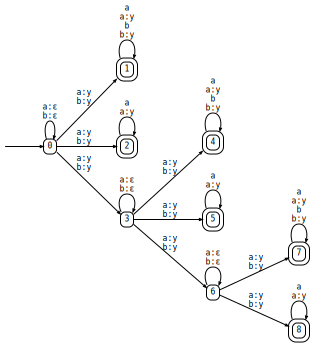

In [25]:
fst, target = layered_witnesses(3, 10)

ip_univ = compute_ip_universal_states(fst)
aiu = check_all_input_universal(fst)
n_states = len(list(fst.states))
print(f"FST: {n_states} states")
print(f"all_input_universal: {aiu}")
print(f"ip_universal_states: {ip_univ}")
print(f"target: {target!r}")

is_fun, counterexample = fst.is_functional()
print('functional:', colors.mark(is_fun), repr(counterexample))


display(fst)

In [26]:
P = Precover(fst, target)
display(P)
P.show_decomposition()

In [27]:
print("Rust profiling stats:")
for n_layers, tlen in [(3, 10), (5, 15), (10, 20)]:
    fst, target = layered_witnesses(n_layers, tlen)
    _, stats = run_rust(fst, target)
    ip_univ = compute_ip_universal_states(fst)
    n_states = len(list(fst.states))
    print(f"\nlayers={n_layers}, tlen={tlen} ({n_states} FST states, {len(ip_univ)} ip-universal):")
    show_stats(stats)

Rust profiling stats:

layers=3, tlen=10 (9 FST states, 3 ip-universal):
  DFA: 56 states, 92 arcs
  q_stops=10 (universal), r_stops=0 (remainder)
  universal: calls=10, true=10, false=0
  sub_bfs: states_visited=0, compute_arcs=0
  timing: total=0.247ms, universal=0.027ms
  >> ALL 10 true results came from witness/cache (zero BFS work!)

layers=5, tlen=15 (15 FST states, 5 ip-universal):
  DFA: 121 states, 212 arcs
  q_stops=15 (universal), r_stops=0 (remainder)
  universal: calls=15, true=15, false=0
  sub_bfs: states_visited=0, compute_arcs=0
  timing: total=0.829ms, universal=0.034ms
  >> ALL 15 true results came from witness/cache (zero BFS work!)

layers=10, tlen=20 (30 FST states, 10 ip-universal):
  DFA: 211 states, 382 arcs
  q_stops=20 (universal), r_stops=0 (remainder)
  universal: calls=20, true=20, false=0
  sub_bfs: states_visited=0, compute_arcs=0
  timing: total=3.363ms, universal=0.134ms
  >> ALL 20 true results came from witness/cache (zero BFS work!)


Again, `sub_bfs_states=0` despite many universality calls. Every universal conclusion
was resolved by the witness check. More layers mean more DFA states (from the
combinatorial fanout), but the witness check handles them all in $O(1)$ per call.

This demonstrates the key benefit: without the witness optimization, each of those
`universal_true` calls would require a full sub-BFS, potentially visiting many DFA states.

---
## Summary

| Test | ip-universal states | Witness hits | BFS needed | Key optimization |
|------|-------------------|-------------|------------|------------------|
| Gated Universal | State 1 | All true calls | No | Witness check (level 2) |
| Complementary Halves | None | N/A | Yes | BFS fallback (level 5) |
| Shrinking Non-Universal | None | N/A | Yes (non-universal) | Negative cache (level 4) |
| Scaled Newspeak | All states | N/A (fast path) | No | all_input_universal (level 1) |
| Layered Witnesses | One per layer | All true calls | No | Witness check (level 2) |

The witness check (level 2) is the most impactful optimization for the generic path:
when ip-universal states exist, it eliminates all BFS work for universal DFA states.
The `all_input_universal` fast path (level 1) is even better but only applies when
*all* FST states are ip-universal.

The monotonicity caches (levels 3 and 4) now use element-indexed lookups instead
of linear scans over stored sets. The positive cache uses hit-counting: for each
element of the query set, it increments a counter for every cached entry containing
that element; when a counter reaches the entry's stored size, the entry is a subset.
The negative cache uses set-intersection of entry-ID sets across query elements.